# Importamos librerias

- yfinance: Fuente de nuestros datos
- pandas: Herramienta para el procesamiento
- matplotlib: Herramienta de visualizacion

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Extract

Obtenemos los datos del stock GLTO teniendo un periodo que inicia en start_date y termina en end_date.

In [ ]:
ticker ="GLTO"
start_date = '2024-09-30'
end_date = '2025-11-11' 
data = yf.download(ticker, start=start_date, end=end_date)
try:
    data.to_csv(f'{ticker}_data.csv')
    print(f"Datos guardados localmente en '{ticker}_data.csv'")
except Exception as e:
    print(f"No se pudo guardar el archivo: {e}")
print("--- Datos Descargados---")
print(data.tail())



/tmp/ipykernel_14422/696721267.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Datos guardados localmente en 'GLTO_data.csv'
--- Datos Descargados---
Price       Close       High     Low       Open    Volume
Ticker       GLTO       GLTO    GLTO       GLTO      GLTO
Date                                                     
2025-11-04   5.96   6.232000   5.844   6.160000     43400
2025-11-05   5.94   6.100000   5.800   5.800000     21700
2025-11-06   5.82   5.970000   5.700   5.850000     20300
2025-11-07   4.95   5.475000   4.950   5.070000     41200
2025-11-10  17.25  25.879999  15.060  21.440001  43784000


# Damos un vistaso a los datos

In [15]:
data = pd.read_csv(f'/home/eliotito/finanzas/{ticker}_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   282 non-null    object
 1   Close   281 non-null    object
 2   High    281 non-null    object
 3   Low     281 non-null    object
 4   Open    281 non-null    object
 5   Volume  281 non-null    object
dtypes: object(6)
memory usage: 13.3+ KB


# Transform
Utilizamos la columna de close que es el costo al cierre de nuestro stock. Como es de tipo objeto lo transformamos a int

In [ ]:
#Seleccionamos la columna con .loc
costo_al_cierre = data.loc[(data['Close'] != f'{ticker}') & (data['Close'].notna()), 'Close']
costo_al_cierre = pd.to_numeric(costo_al_cierre, errors='coerce')


# SMA corta y larga

Nos servira para ver como va el precio del stock, en un periodo corto y uno largo 

In [ ]:
sma_corta_periodo = 10
sma_larga_periodo = 30

data[f'SMA_{sma_corta_periodo}'] = costo_al_cierre.rolling(window=sma_corta_periodo).mean()
data[f'SMA_{sma_larga_periodo}'] = costo_al_cierre.rolling(window=sma_larga_periodo).mean()
data = data.dropna()

print("\n--- Datos con Medias Móviles ---")
print(data.head())
if data.empty:
    print("No hay datos descargados. Revisa el rango de fechas o el ticker.")


--- Datos con Medias Móviles (primeros 5 días) ---
         Price              Close               High                 Low  \
31  2024-11-08  7.090000152587891  7.099999904632568   6.849999904632568   
32  2024-11-11  7.079999923706055  7.090000152587891  6.9670000076293945   
33  2024-11-12                7.0  7.050000190734863   6.809999942779541   
34  2024-11-13  6.889999866485596  6.889999866485596   6.690000057220459   
35  2024-11-14  6.920000076293945  6.940000057220459    6.78000020980835   

                  Open Volume  SMA_10    SMA_30  
31   7.099999904632568  11800   7.018  7.861000  
32  6.9670000076293945   6400   7.000  7.692000  
33   7.050000190734863  12000   6.992  7.536333  
34   6.888000011444092   4200   6.950  7.386000  
35    6.78000020980835   3400   6.957  7.222000  


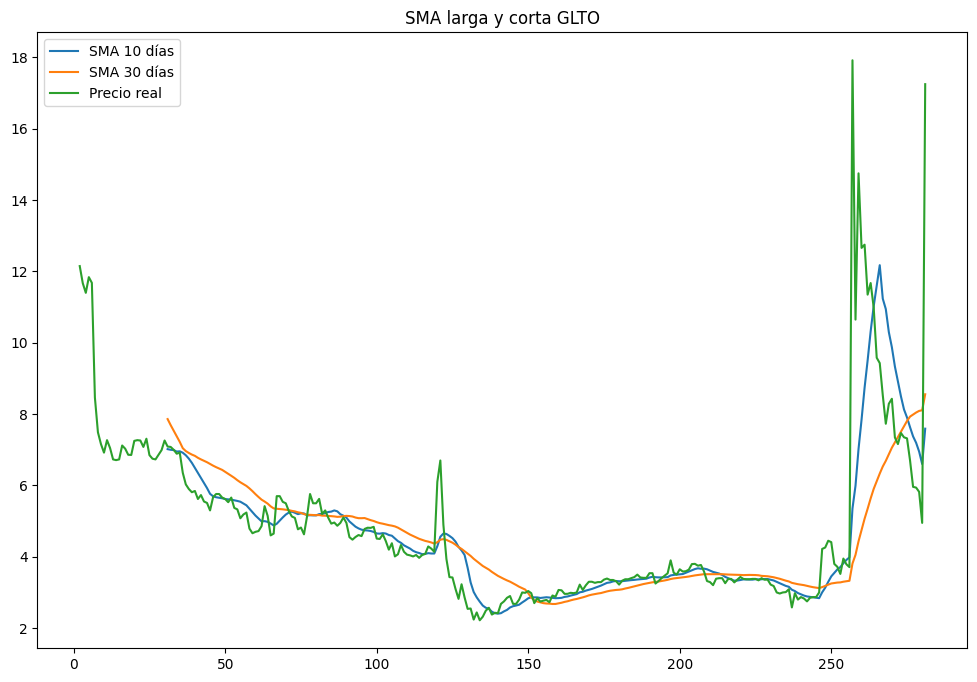

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data[f'SMA_{sma_corta_periodo}'], label=f'SMA {sma_corta_periodo} días')
ax.plot(data[f'SMA_{sma_larga_periodo}'], label=f'SMA {sma_larga_periodo} días')
ax.plot(costo_al_cierre,label=f'Precio real')
ax.legend()
plt.title(f'SMA larga y corta {ticker}')
plt.show()


# EMA

Medida parecida al SMA pero mas precisa.

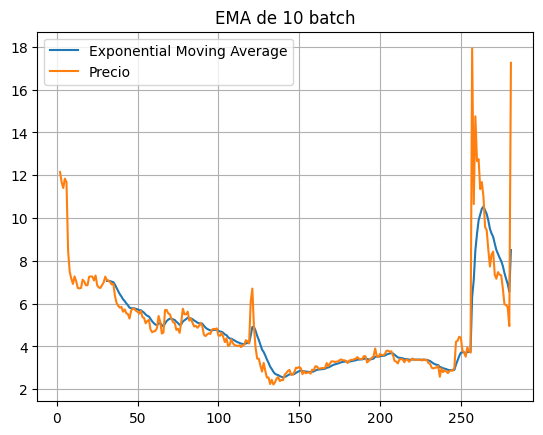

In [ ]:
data['EMA_10'] = costo_al_cierre.ewm(span=10, adjust=False).mean()
plt.plot(data['EMA_10'],label='Exponential Moving Average')
plt.plot(costo_al_cierre, label='Precio')
plt.legend()
plt.title('EMA de 10 batch')
plt.grid()
plt.show()

# Bollinger Bands

Medida usada para ver la volatilidad de una accion asi como un posible tendencia altista y bajista,

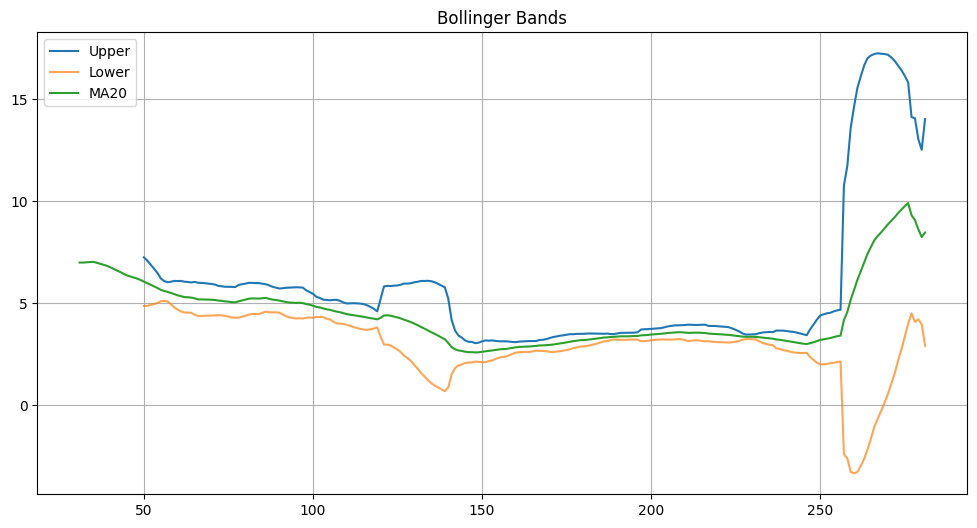

In [ ]:
data['MA20'] = costo_al_cierre.rolling(window=20).mean()
data['Upper'] = data['MA20'] + 2 * costo_al_cierre.rolling(window=20).std()
data['Lower'] = data['MA20'] - 2 * costo_al_cierre.rolling(window=20).std()
fig,ax =plt.subplots(figsize=(12,6))
ax.plot(data['Upper'], label='Upper')
ax.plot(data['Lower'],label='Lower', alpha = 0.7)
ax.plot(data['MA20'], label='MA20')
plt.grid()
plt.title('Bollinger Bands')
plt.legend()
plt.show()

# RSI

Ayuda a identificar si un activo está potencialmente sobrecomprado (por encima de 70) o sobrevendido (por debajo de 30).

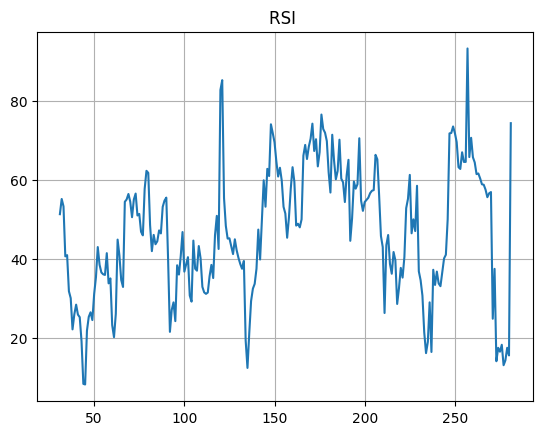

In [ ]:
delta = costo_al_cierre.diff()  #Estudiar esto
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))
plt.plot(data['RSI'])
plt.title(' RSI ')
plt.grid()
plt.show()

# Rendimiento acumulado
Nos dice cuanto hemos ganado o perdido en base a 1 dolar

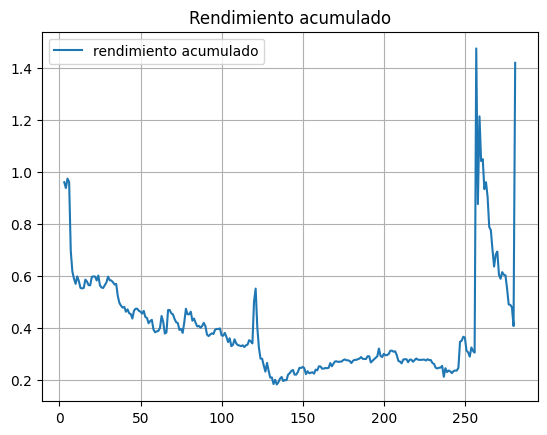

In [ ]:
returns = costo_al_cierre.pct_change()
cumulative = (1 + returns).cumprod() #Estudiar esto
plt.plot(cumulative,label='rendimiento acumulado')
plt.legend()
plt.title('Rendimiento acumulado')
plt.grid()
plt.show()


# MACD Y SIGNAL

MACD: Es la línea principal del indicador y representa la diferencia entre una media móvil exponencial (EMA) de 12 periodos y una EMA de 26 periodos.

SIGNAL: Se usa junto con la línea MACD para generar señales de compra y venta. 

Histograma: Muestra la diferencia entre las dos líneas y puede usarse para confirmar la fuerza de la tendencia. 


- Señal de compra: Cuando la línea MACD cruza por encima de la línea de señal.
- Señal de venta: Cuando la línea MACD cruza por debajo de la línea de señal.

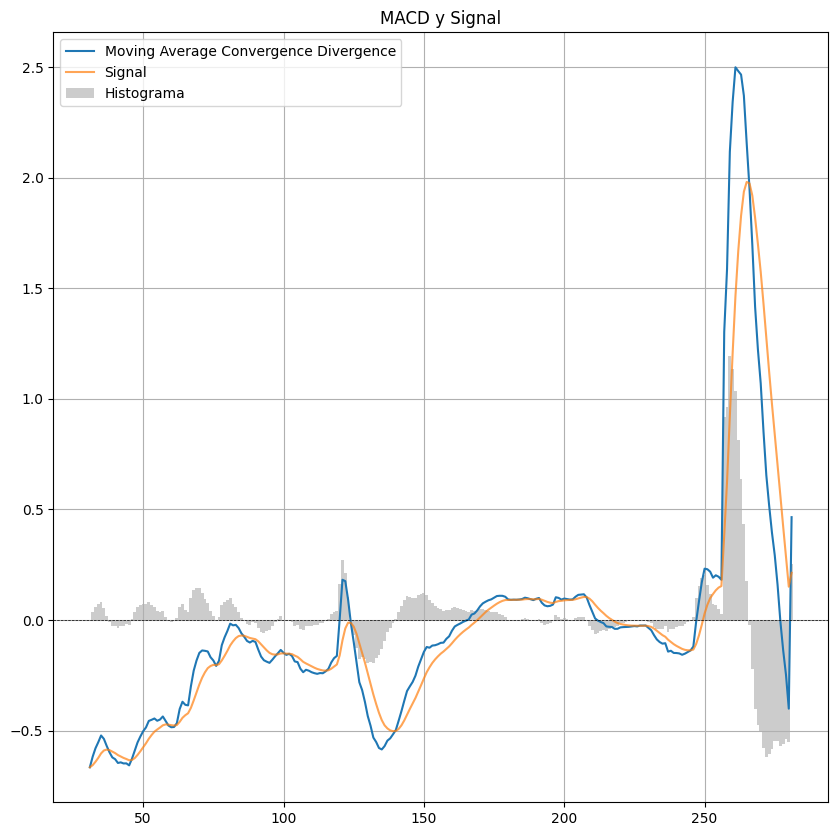

In [ ]:
data['EMA_12'] = costo_al_cierre.ewm(span=12, adjust=False).mean()
data['EMA_26'] = costo_al_cierre.ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean() #Estudiar ewm
data['Histograma'] = data['MACD'] - data['Signal']


fig,ax =plt.subplots(figsize=(10,10))
ax.plot(data['MACD'], label='Moving Average Convergence Divergence')
plt.plot(data['Signal'],label='Signal', alpha = 0.7)

ax.bar(data.index, data['Histograma'], label='Histograma', color='grey', alpha=0.4, width=1.0)
ax.axhline(0, linestyle='--', color='black', linewidth=0.5)


plt.title('MACD y Signal')
plt.grid()
plt.legend()
plt.show()


# Load

Guardamos los datos procesados para futuro analisis.

In [26]:
data.to_csv('GLTO_Clean_data.csv',index=False)